c:\Users\david\anaconda3\envs\azureml-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


   Bankrupt  ROAC_before_interest_and_depreciation_before_interest  \
0         0                                           0.390923       
1         0                                           0.508361       
2         0                                           0.488519       
3         0                                           0.495686       
4         0                                           0.482475       

   ROAA_before_interest_and_pct_after_tax  \
0                                0.445704   
1                                0.570922   
2                                0.545137   
3                                0.550916   
4                                0.567543   

   ROAB_before_interest_and_depreciation_after_tax  Operating_Gross_Margin  \
0                                         0.436158                0.619950   
1                                         0.559077                0.601738   
2                                         0.543284                0.603612

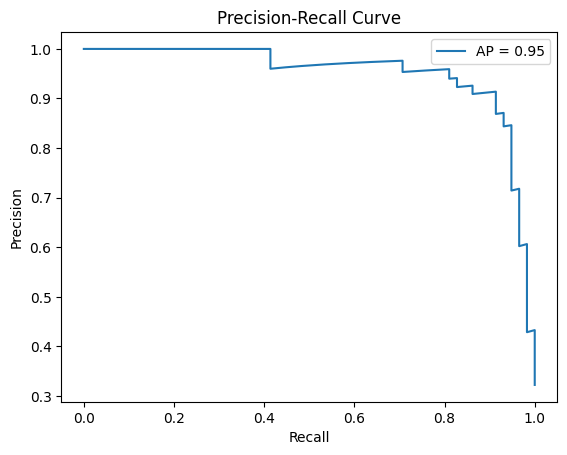

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd

path = kagglehub.dataset_download("fedesoriano/company-bankruptcy-prediction")
data = pd.read_csv(path+"/data.csv")

df_0 = data[data["Bankrupt?"] == 0].head(400)
df_1 = data[data["Bankrupt?"] == 1].head(200)

df_subset = pd.concat([df_0, df_1])

df_subset = df_subset.reset_index(drop=True)
df_subset.columns = (
    df_subset.columns
    .str.strip()
    .str.replace(' ', '_')
    .str.replace('%', 'pct')
    .str.replace('?', '')
    .str.replace('(', '')
    .str.replace(')', '')
)

print(df_subset.head())

X = pd.DataFrame(df_subset.drop("Bankrupt",  axis=1))
y = pd.Series(df_subset["Bankrupt"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


neg_count = np.sum(y_train == 0)
pos_count = np.sum(y_train == 1)
scale_pos_weight = neg_count / pos_count 



model_weighted = lgb.LGBMClassifier(
    random_state=42,
    boosting_type='gbdt',
    n_estimators=100,
    learning_rate=0.05,
    scale_pos_weight=scale_pos_weight  
)
model_weighted.fit(X_train, y_train)

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  

    print(classification_report(y_test, y_pred))
    
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    ap_score = average_precision_score(y_test, y_proba)
    
    plt.figure()
    plt.plot(recall, precision, label=f'AP = {ap_score:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()


print("\n=== Weighted LightGBM ===")
evaluate_model(model_weighted, X_test, y_test)

In [2]:
import joblib
joblib.dump(model_weighted, 'model.pkl')

['model.pkl']

In [ ]:
scorepy = """
import json
import joblib
import numpy as np
import pandas as pd
from azureml.core.model import Model

def init():
    global model
    model_path = Model.get_model_path("model")
    model = joblib.load(model_path)

def run(raw_data):
    try:
        data = json.loads(raw_data)["data"]
        df = pd.DataFrame(data)
        prediction = model.predict(df).tolist()
        return json.dumps(prediction)
    except Exception as e:
        return json.dumps({"error": str(e)})
"""

with open("score.py", "w") as file_score:
    file_score.write(scorepy)

print("✅ Archivo score.py generado.")
        

✅ Archivo score.py generado.


In [ ]:
from azureml.core import Workspace

ws = Workspace.create(
    name="bankrupt_dataprophet_v3",
    subscription_id="f7573334-1f4f-4ce7-9b75-ce1f32e6bd37",
    resource_group="group_1",
    location="centralindia", 
)

ws.write_config()
print("✅ Workspace created and config saved.")


Deploying AppInsights with name bankruptinsightsb598b79f.
Deployed AppInsights with name bankruptinsightsb598b79f. Took 9.74 seconds.
Deploying KeyVault with name bankruptkeyvault785fe77c.
Deploying StorageAccount with name bankruptstorage2ec669fc1.
Deployed KeyVault with name bankruptkeyvault785fe77c. Took 25.98 seconds.
Deploying Workspace with name bankrupt_dataprophet_v3.
Deployed StorageAccount with name bankruptstorage2ec669fc1. Took 30.39 seconds.
Deployed Workspace with name bankrupt_dataprophet_v3. Took 42.5 seconds.
✅ Workspace created and config saved.


In [15]:
from azureml.core import Workspace

ws = Workspace.get(
    name="bankrupt_dataprophet_v3",
    subscription_id="f7573334-1f4f-4ce7-9b75-ce1f32e6bd37",
    resource_group="group_1"
)


In [16]:
from azureml.core.model import Model

registered_model = Model.register(
    model_path="model.pkl",
    model_name="bankrupt_predict",
    workspace=ws
)


Registering model bankrupt_predict


In [17]:
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies

env = Environment("bankrupt_env_v3")
deps = CondaDependencies.create(
    conda_packages=["python=3.8", "numpy", "pandas", "scikit-learn", "joblib", "lightgbm"],
    pip_packages=["azureml-defaults"]
)
env.python.conda_dependencies = deps


In [ ]:
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice

inference_config = InferenceConfig(entry_script="score.py", environment=env)
deployment_config = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=1)

service = Model.deploy(
    workspace=ws,
    name="bankrupt-service-v3",
    models=[registered_model], 
    inference_config=inference_config,
    deployment_config=deployment_config
)


C:\Users\david\AppData\Local\Temp\ipykernel_28592\2584490616.py:7: FutureWarning: azureml.core.model:
To leverage new model deployment capabilities, AzureML recommends using CLI/SDK v2 to deploy models as online endpoint, 
please refer to respective documentations 
https://docs.microsoft.com/azure/machine-learning/how-to-deploy-managed-online-endpoints /
https://docs.microsoft.com/azure/machine-learning/how-to-attach-kubernetes-anywhere 
For more information on migration, see https://aka.ms/acimoemigration 
To disable CLI/SDK v1 deprecation warning set AZUREML_LOG_DEPRECATION_WARNING_ENABLED to 'False'
  service = Model.deploy(


In [ ]:
service.wait_for_deployment(show_output=True)
print("Servicio desplegado. URI:", service.scoring_uri)


Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2025-04-24 16:53:01-06:00 Creating Container Registry if not exists.
2025-04-24 16:53:02-06:00 Use the existing image.
2025-04-24 16:53:04-06:00 Generating deployment configuration.
2025-04-24 16:53:06-06:00 Submitting deployment to compute.
2025-04-24 16:53:14-06:00 Checking the status of deployment bankrupt-service-v3..
2025-04-24 16:55:01-06:00 Checking the status of inference endpoint bankrupt-service-v3.
Succeeded
ACI service creation operation finished, operation "Succeeded"
✅ Servicio desplegado. URI: http://5dd53dd1-08c1-4bce-9459-a3379caaf848.centralindia.azurecontainer.io/score
